Installing necessary packages

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Downloading 2 qubit dataset

In [ ]:
files.upload()

! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d alikookani/quantangle1
! mkdir train
! unzip quantangle1.zip -d train

Saving kaggle.json to kaggle.json
 98% 198M/203M [00:02<00:00, 94.0MB/s]
100% 203M/203M [00:02<00:00, 81.9MB/s]
Archive:  quantangle1.zip
  inflating: train/mydata.csv        


Opening the dataset

In [ ]:
data = pd.read_csv (r'/content/train/mydata.csv')
data = np.array(data)

Separating real and imaginary values

In [ ]:
vector = np.empty([1000000, 32], dtype=float)
for i in range(1000000):
  for j in range(16):
    vector[i, 2 * j] = complex(data[i, j]).real
    vector[i, 2 * j + 1] = complex(data[i, j]).imag

Reshaping to 3D tensor format

In [ ]:
matrix = vector.reshape(1000000, 4, 8)
tensor = matrix.reshape(1000000, 4, 4, 2)

Shuffling the dataset for Neural Network

In [ ]:
vec_4_NN = np.empty([1000000, 32], dtype=float)
reg_label = np.empty([1000000], dtype=float)
class_label = np.ones(1000000).astype('int')
for i in range(500000):
  vec_4_NN[2 * i, :] = vector[i, :]
  reg_label[2 * i] = complex(data[i, 17]).real
  class_label[2 * i] = 0
  vec_4_NN[2 * i + 1, :] = vector[i + 500000, :]
  reg_label[2 * i + 1] = complex(data[i + 500000, 17]).real

Shuffling the dataset for convolutional models

In [ ]:
tensr_4_DM = np.empty([1000000, 4, 4, 2], dtype=float)
reg_label = np.empty([1000000], dtype=float)
class_label = np.ones(1000000).astype('int')
for i in range(500000):
  tensr_4_DM[2 * i, :, :, :] = tensor[i, :, :, :]
  reg_label[2 * i] = complex(data[i, 17]).real
  class_label[2 * i] = 0
  tensr_4_DM[2 * i + 1, :, :, :] = tensor[i + 500000, :, :, :]
  reg_label[2 * i + 1] = complex(data[i + 500000, 17]).real

Neural Network

In [ ]:
NN = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(), input_shape=(32,)),
  tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3233 (12.63 KB)
Trainable params: 3233 (12.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compiling and training NN

In [ ]:
NN.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=tf.keras.metrics.binary_accuracy)
callback_list = [
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath = 'NN.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 )
]
history = NN.fit(
    x=vec_4_NN[:980000, :],
    y=class_label[:980000],
    epochs=14,
    batch_size=125,
    callbacks = callback_list,
    validation_data=(vec_4_NN[980000:990000, :], class_label[980000:990000])
    )

Epoch 1/14
7840/7840 [==============================] - 28s 3ms/step - loss: 0.6861 - binary_accuracy: 0.6061 - val_loss: 0.6789 - val_binary_accuracy: 0.6508
Epoch 2/14
  60/7840 [..............................] - ETA: 20s - loss: 0.6786 - binary_accuracy: 0.6529

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7840/7840 [==============================] - 22s 3ms/step - loss: 0.6674 - binary_accuracy: 0.6796 - val_loss: 0.6498 - val_binary_accuracy: 0.7179
Epoch 3/14
7840/7840 [==============================] - 24s 3ms/step - loss: 0.6109 - binary_accuracy: 0.7444 - val_loss: 0.5603 - val_binary_accuracy: 0.7670
Epoch 4/14
7840/7840 [==============================] - 23s 3ms/step - loss: 0.5000 - binary_accuracy: 0.7816 - val_loss: 0.4490 - val_binary_accuracy: 0.8039
Epoch 5/14
7840/7840 [==============================] - 23s 3ms/step - loss: 0.4225 - binary_accuracy: 0.8079 - val_loss: 0.4354 - val_binary_accuracy: 0.7902
Epoch 6/14
7840/7840 [==============================] - 25s 3ms/step - loss: 0.3984 - binary_accuracy: 0.8160 - val_loss: 0.3877 - val_binary_accuracy: 0.8253
Epoch 7/14
7840/7840 [==============================] - 28s 4ms/step - loss: 0.3895 - binary_accuracy: 0.8198 - val_loss: 0.3827 - val_binary_accuracy: 0.8244
Epoch 8/14
7840/7840 [==============================] - 2

Depicting performanc of NN results

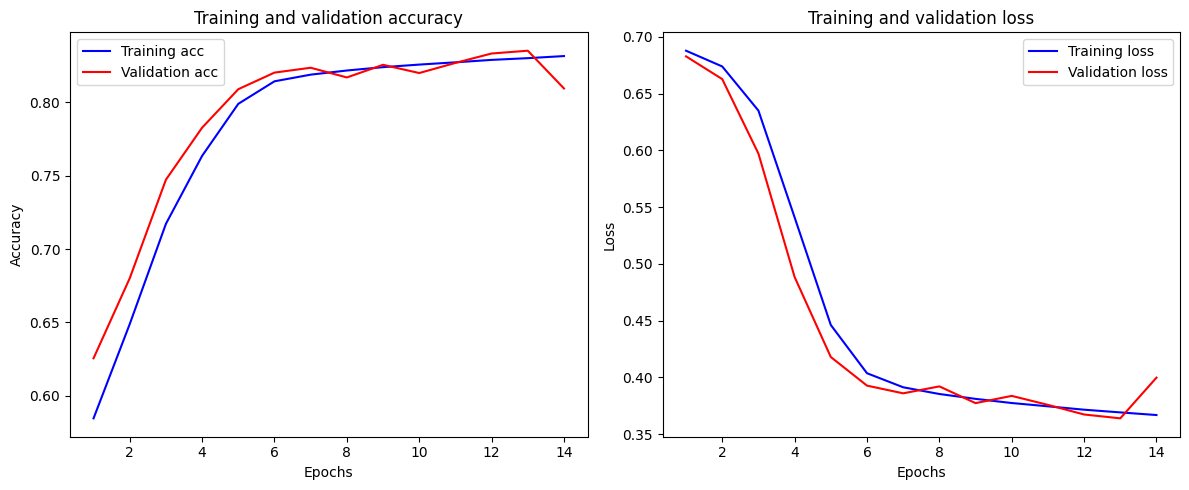

In [ ]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Create two subplots: one for accuracy and one for loss
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Ensures that the subplots don't overlap
plt.show()

Evaluating NN

In [ ]:
my_model = tf.keras.models.load_model("NN.h5")
my_model.evaluate(vec_4_NN[990000:1000000, :], class_label[990000:1000000])

313/313 [==============================] - 1s 2ms/step - loss: 0.3682 - binary_accuracy: 0.8299


[0.36815598607063293, 0.8299000263214111]

313/313 [==============================] - 1s 3ms/step


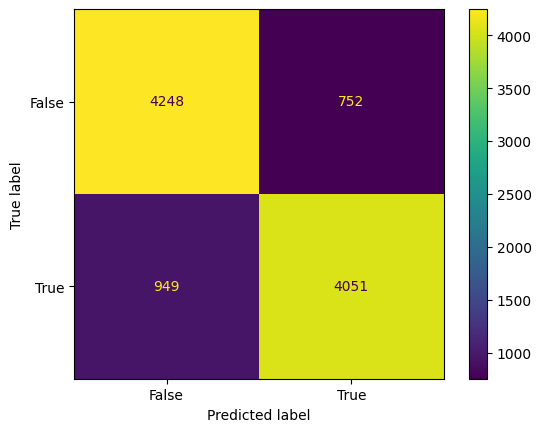

In [ ]:
from sklearn import metrics as sklearn_metrics  # Renamed sklearn's metrics

# Make predictions and create a confusion matrix
actual = class_label[990000:1000000]
seq_predictions = my_model.predict(vec_4_NN[990000:1000000, :])
seq_predictions = np.transpose(seq_predictions)[0]
seq_predictions = list(map(lambda x: 0 if x < 0.5 else 1, seq_predictions))

# Calculate the confusion matrix using sklearn metrics
confusion_matrix = sklearn_metrics.confusion_matrix(actual, seq_predictions)

# Display the confusion matrix
cm_display = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

Simple convolution

In [ ]:
input_tensor = tf.keras.Input(shape=(4, 4, 2))
layer1 = tf.keras.layers.Conv2D(64, 1)(input_tensor)
layer1 = tf.keras.layers.LeakyReLU()(layer1)
layer2 = tf.keras.layers.Conv2D(64, 1)(layer1)
layer2 = tf.keras.layers.LeakyReLU()(layer2)
layer3 = tf.keras.layers.Conv2D(128, 2)(layer2)
layer3 = tf.keras.layers.LeakyReLU()(layer3)
layer4 = tf.keras.layers.Conv2D(128, 1)(layer3)
layer4 = tf.keras.layers.LeakyReLU()(layer4)
layer5 = tf.keras.layers.Conv2D(128, 2)(layer4)
layer5 = tf.keras.layers.LeakyReLU()(layer5)
layer6 = tf.keras.layers.Conv2D(256, 1)(layer5)
layer6 = tf.keras.layers.LeakyReLU()(layer6)
layer7 = tf.keras.layers.Conv2D(256, 2)(layer6)
layer7 = tf.keras.layers.LeakyReLU()(layer7)
layer8 = tf.keras.layers.Conv2D(512, 1)(layer7)
layer8 = tf.keras.layers.LeakyReLU()(layer8)
layer9 = tf.keras.layers.Conv2D(512, 1)(layer8)
layer9 = tf.keras.layers.LeakyReLU()(layer9)
layer10 = tf.keras.layers.Conv2D(512, 1)(layer9)
layer10 = tf.keras.layers.LeakyReLU()(layer10)
top1 = tf.keras.layers.Flatten()(layer10)
top1 = tf.keras.layers.Dense(512)(top1)
top1 = tf.keras.layers.LeakyReLU()(top1)

top2 = tf.keras.layers.Dense(1)(top1)
top2 = tf.keras.layers.Activation('sigmoid')(top2)

model = tf.keras.models.Model(input_tensor, top2)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 4, 2)]         0         
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 64)          192       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          4160      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         32896     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 3, 3, 128)         0     

Compiling and training simple convolution

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=tf.keras.metrics.binary_accuracy)
callback_list = [
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath = 'model.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 )
]
history = model.fit(
    tensr_4_DM[:980000, :, :, :],
    class_label[:980000],
    batch_size = 125,
    epochs = 14,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :], class_label[980000:990000]),
)

Epoch 1/14
7840/7840 [==============================] - 53s 6ms/step - loss: 0.6140 - binary_accuracy: 0.6814 - val_loss: 0.4015 - val_binary_accuracy: 0.8133
Epoch 2/14
  21/7840 [..............................] - ETA: 41s - loss: 0.4099 - binary_accuracy: 0.8107

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7840/7840 [==============================] - 56s 7ms/step - loss: 0.3673 - binary_accuracy: 0.8306 - val_loss: 0.3172 - val_binary_accuracy: 0.8563
Epoch 3/14
7840/7840 [==============================] - 46s 6ms/step - loss: 0.3023 - binary_accuracy: 0.8616 - val_loss: 0.2740 - val_binary_accuracy: 0.8750
Epoch 4/14
7840/7840 [==============================] - 47s 6ms/step - loss: 0.2711 - binary_accuracy: 0.8769 - val_loss: 0.2448 - val_binary_accuracy: 0.8881
Epoch 5/14
7840/7840 [==============================] - 47s 6ms/step - loss: 0.2452 - binary_accuracy: 0.8892 - val_loss: 0.2509 - val_binary_accuracy: 0.8864
Epoch 6/14
7840/7840 [==============================] - 46s 6ms/step - loss: 0.2144 - binary_accuracy: 0.9042 - val_loss: 0.1847 - val_binary_accuracy: 0.9187
Epoch 7/14
7840/7840 [==============================] - 48s 6ms/step - loss: 0.1822 - binary_accuracy: 0.9192 - val_loss: 0.1580 - val_binary_accuracy: 0.9304
Epoch 8/14
7840/7840 [==============================] - 4

Depicting performanc of simple convolutional model results

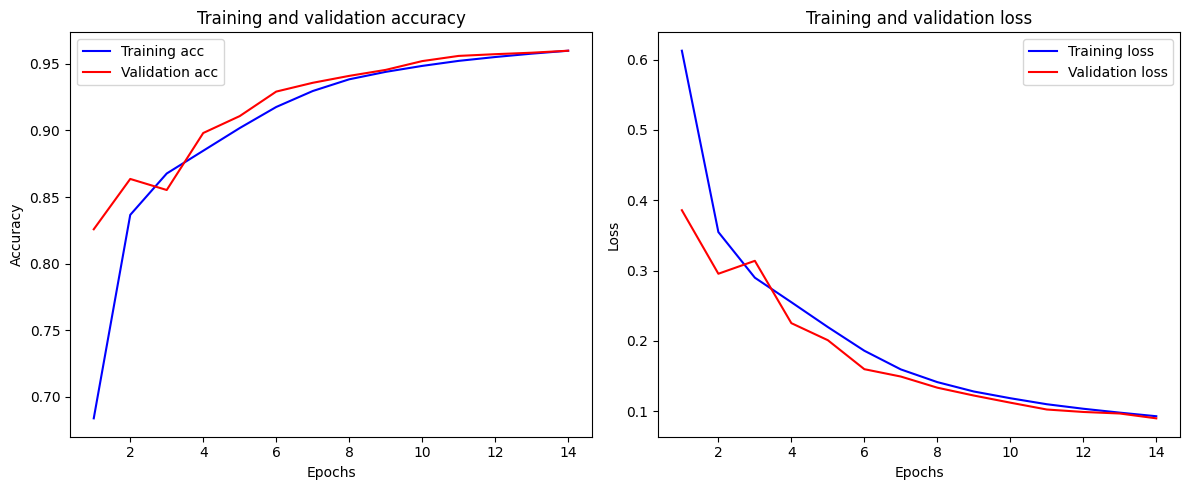

In [ ]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Create two subplots: one for accuracy and one for loss
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Ensures that the subplots don't overlap
plt.show()

Evaluating simple convolutional model

In [ ]:
my_model = tf.keras.models.load_model("model.h5")
my_model.evaluate(tensr_4_DM[990000:1000000, :, :, :], class_label[990000:1000000])

313/313 [==============================] - 2s 4ms/step - loss: 0.0986 - binary_accuracy: 0.9589


[0.09859198331832886, 0.958899974822998]

313/313 [==============================] - 1s 2ms/step


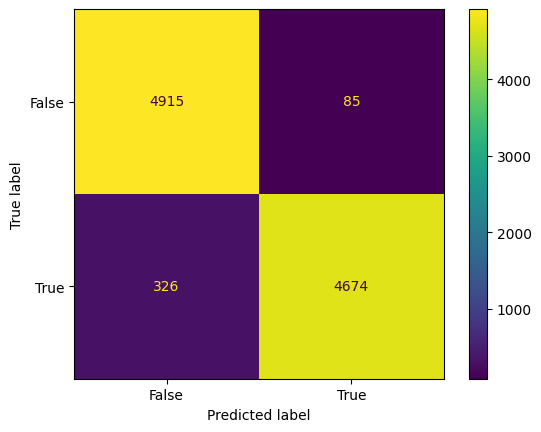

In [ ]:
# Make predictions and create a confusion matrix
actual = class_label[990000:1000000]
seq_predictions = my_model.predict(tensr_4_DM[990000:1000000, :, :])
seq_predictions = np.transpose(seq_predictions)[0]
seq_predictions = list(map(lambda x: 0 if x < 0.5 else 1, seq_predictions))

# Calculate the confusion matrix using sklearn metrics
confusion_matrix = sklearn_metrics.confusion_matrix(actual, seq_predictions)

# Display the confusion matrix
cm_display = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

Branched convolutional model

In [ ]:
input_tensor = tf.keras.Input(shape=(4, 4, 2))
layer1 = tf.keras.layers.Conv2D(64, 1)(input_tensor)
layer1 = tf.keras.layers.LeakyReLU()(layer1)
layer2 = tf.keras.layers.Conv2D(64, 1)(layer1)
layer2 = tf.keras.layers.LeakyReLU()(layer2)
branch_a = tf.keras.layers.Conv2D(256, 4)(layer2)
branch_a = tf.keras.layers.LeakyReLU()(branch_a)
branch_a = tf.keras.layers.Conv2D(128, 1)(branch_a)
branch_a = tf.keras.layers.LeakyReLU()(branch_a)
branch_b = tf.keras.layers.Conv2D(192, 3)(layer2)
branch_b = tf.keras.layers.LeakyReLU()(branch_b)
layer3 = tf.keras.layers.Conv2D(128, 2)(layer2)
layer3 = tf.keras.layers.LeakyReLU()(layer3)
layer4 = tf.keras.layers.Conv2D(128, 1)(layer3)
layer4 = tf.keras.layers.LeakyReLU()(layer4)
branch_c = tf.keras.layers.Conv2D(96, 3)(layer4)
branch_c = tf.keras.layers.LeakyReLU()(branch_c)
layer5 = tf.keras.layers.Conv2D(128, 2)(layer4)
layer5 = tf.keras.layers.LeakyReLU()(layer5)
layer5 = tf.keras.layers.concatenate([layer5, branch_b], axis=-1)
layer6 = tf.keras.layers.Conv2D(256, 1)(layer5)
layer6 = tf.keras.layers.LeakyReLU()(layer6)
layer7 = tf.keras.layers.Conv2D(256, 2)(layer6)
layer7 = tf.keras.layers.LeakyReLU()(layer7)
layer7 = tf.keras.layers.concatenate([layer7, branch_a], axis=-1)
layer8 = tf.keras.layers.Conv2D(512, 1)(layer7)
layer8 = tf.keras.layers.LeakyReLU()(layer8)
layer8 = tf.keras.layers.concatenate([layer8, branch_c], axis=-1)
layer9 = tf.keras.layers.Conv2D(512, 1)(layer8)
layer9 = tf.keras.layers.LeakyReLU()(layer9)
layer10 = tf.keras.layers.Conv2D(512, 1)(layer9)
layer10 = tf.keras.layers.LeakyReLU()(layer10)
top1 = tf.keras.layers.Flatten()(layer10)
top1 = tf.keras.layers.Dense(512)(top1)
top1 = tf.keras.layers.LeakyReLU()(top1)

top2 = tf.keras.layers.Dense(1)(top1)
top2 = tf.keras.layers.Activation('sigmoid')(top2)

model1 = tf.keras.models.Model(input_tensor, top2)
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4, 4, 2)]            0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 4, 4, 64)             192       ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu_13 (LeakyReLU)  (None, 4, 4, 64)             0         ['conv2d_10[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)          (None, 4, 4, 64)             4160      ['leaky_re_lu_13[0][0]']      
                                                                                            

Compiling and training branched convolutional model

In [ ]:
model1.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=tf.keras.metrics.binary_accuracy)
callback_list = [
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath = 'model1.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 )
]
history = model1.fit(
    tensr_4_DM[:980000, :, :, :],
    class_label[:980000],
    batch_size = 125,
    epochs = 14,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :], class_label[980000:990000]),
)

Epoch 1/14
7840/7840 [==============================] - 75s 9ms/step - loss: 0.5980 - binary_accuracy: 0.7197 - val_loss: 0.3779 - val_binary_accuracy: 0.8281
Epoch 2/14
   6/7840 [..............................] - ETA: 1:25 - loss: 0.3795 - binary_accuracy: 0.8320

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7840/7840 [==============================] - 68s 9ms/step - loss: 0.3519 - binary_accuracy: 0.8378 - val_loss: 0.2931 - val_binary_accuracy: 0.8640
Epoch 3/14
7840/7840 [==============================] - 67s 9ms/step - loss: 0.2904 - binary_accuracy: 0.8666 - val_loss: 0.2548 - val_binary_accuracy: 0.8815
Epoch 4/14
7840/7840 [==============================] - 64s 8ms/step - loss: 0.2560 - binary_accuracy: 0.8843 - val_loss: 0.2162 - val_binary_accuracy: 0.9046
Epoch 5/14
7840/7840 [==============================] - 70s 9ms/step - loss: 0.2141 - binary_accuracy: 0.9044 - val_loss: 0.1734 - val_binary_accuracy: 0.9248
Epoch 6/14
7840/7840 [==============================] - 57s 7ms/step - loss: 0.1698 - binary_accuracy: 0.9255 - val_loss: 0.1537 - val_binary_accuracy: 0.9305
Epoch 7/14
7840/7840 [==============================] - 86s 11ms/step - loss: 0.1431 - binary_accuracy: 0.9376 - val_loss: 0.1354 - val_binary_accuracy: 0.9397
Epoch 8/14
7840/7840 [==============================] - 

Depicting performanc of branched convolutional model results

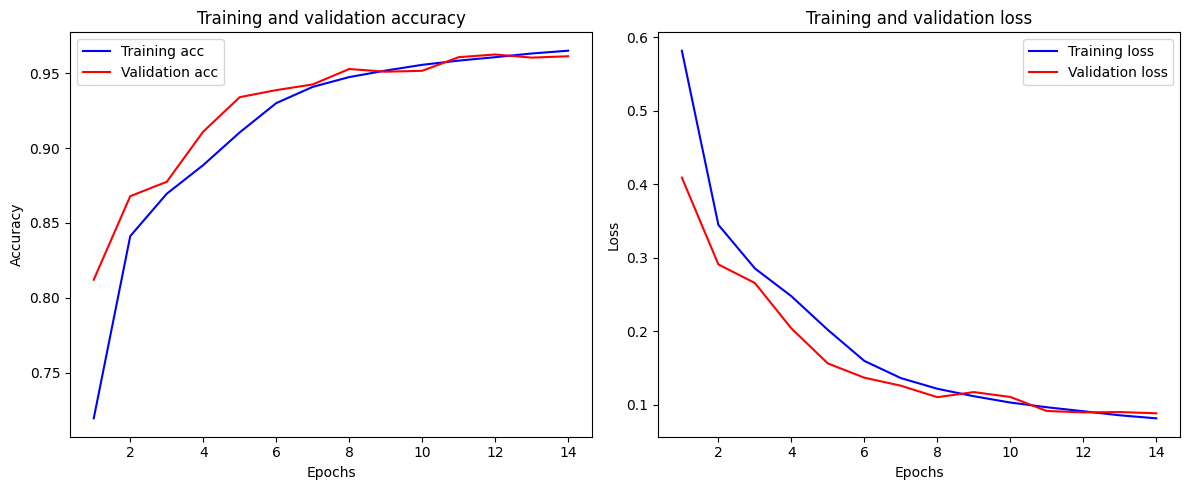

In [ ]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Create two subplots: one for accuracy and one for loss
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Ensures that the subplots don't overlap
plt.show()

Evaluating branched convolutional model

In [ ]:
my_model = tf.keras.models.load_model("model1.h5")
my_model.evaluate(tensr_4_DM[990000:1000000, :, :, :], class_label[990000:1000000])

313/313 [==============================] - 2s 4ms/step - loss: 0.0842 - binary_accuracy: 0.9638


[0.08415893465280533, 0.9638000130653381]

313/313 [==============================] - 1s 3ms/step


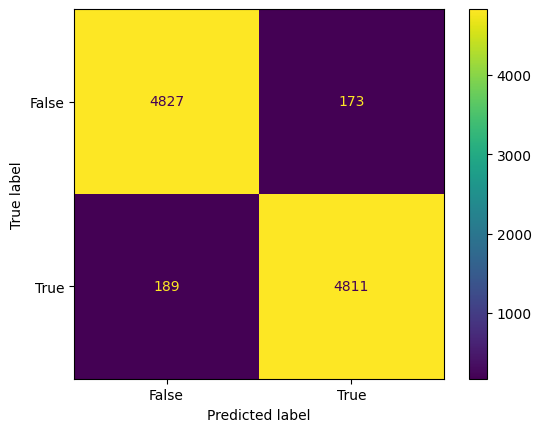

In [ ]:
# Make predictions and create a confusion matrix
actual = class_label[990000:1000000]
seq_predictions = my_model.predict(tensr_4_DM[990000:1000000, :, :])
seq_predictions = np.transpose(seq_predictions)[0]
seq_predictions = list(map(lambda x: 0 if x < 0.5 else 1, seq_predictions))

# Calculate the confusion matrix using sklearn metrics
confusion_matrix = sklearn_metrics.confusion_matrix(actual, seq_predictions)

# Display the confusion matrix
cm_display = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

Model with batch norm & sep conv techniques

In [ ]:
input_tensor = tf.keras.Input(shape=(4, 4, 2))
layer1 = tf.keras.layers.SeparableConv2D(64, 1)(input_tensor)
layer1 = tf.keras.layers.BatchNormalization()(layer1)
layer1 = tf.keras.layers.LeakyReLU()(layer1)
layer2 = tf.keras.layers.SeparableConv2D(64, 1)(layer1)
layer2 = tf.keras.layers.BatchNormalization()(layer2)
layer2 = tf.keras.layers.LeakyReLU()(layer2)
layer3 = tf.keras.layers.SeparableConv2D(128, 2)(layer2)
layer3 = tf.keras.layers.BatchNormalization()(layer3)
layer3 = tf.keras.layers.LeakyReLU()(layer3)
layer4 = tf.keras.layers.SeparableConv2D(128, 1)(layer3)
layer4 = tf.keras.layers.BatchNormalization()(layer4)
layer4 = tf.keras.layers.LeakyReLU()(layer4)
layer5 = tf.keras.layers.SeparableConv2D(128, 2)(layer4)
layer5 = tf.keras.layers.BatchNormalization()(layer5)
layer5 = tf.keras.layers.LeakyReLU()(layer5)
layer6 = tf.keras.layers.SeparableConv2D(256, 1)(layer5)
layer6 = tf.keras.layers.BatchNormalization()(layer6)
layer6 = tf.keras.layers.LeakyReLU()(layer6)
layer7 = tf.keras.layers.SeparableConv2D(256, 2)(layer6)
layer7 = tf.keras.layers.BatchNormalization()(layer7)
layer7 = tf.keras.layers.LeakyReLU()(layer7)
layer8 = tf.keras.layers.SeparableConv2D(512, 1)(layer7)
layer8 = tf.keras.layers.BatchNormalization()(layer8)
layer8 = tf.keras.layers.LeakyReLU()(layer8)
layer9 = tf.keras.layers.SeparableConv2D(512, 1)(layer8)
layer9 = tf.keras.layers.BatchNormalization()(layer9)
layer9 = tf.keras.layers.LeakyReLU()(layer9)
layer10 = tf.keras.layers.SeparableConv2D(512, 1)(layer9)
layer10 = tf.keras.layers.BatchNormalization()(layer10)
layer10 = tf.keras.layers.LeakyReLU()(layer10)
top1 = tf.keras.layers.Flatten()(layer10)
top1 = tf.keras.layers.Dense(512)(top1)
top1 = tf.keras.layers.BatchNormalization()(top1)
top1 = tf.keras.layers.LeakyReLU()(top1)

top2 = tf.keras.layers.Dense(1)(top1)
top2 = tf.keras.layers.BatchNormalization()(top2)
top2 = tf.keras.layers.Activation('sigmoid')(top2)

model2 = tf.keras.models.Model(input_tensor, top2)
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 4, 2)]         0         
                                                                 
 separable_conv2d (Separabl  (None, 4, 4, 64)          194       
 eConv2D)                                                        
                                                                 
 batch_normalization (Batch  (None, 4, 4, 64)          256       
 Normalization)                                                  
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 4, 4, 64)          0         
                                                                 
 separable_conv2d_1 (Separa  (None, 4, 4, 64)          4224      
 bleConv2D)                                                      
                                                           

Compiling and training model with batch norm & sep conv techniques

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=tf.keras.metrics.binary_accuracy)
callback_list = [
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath = 'model2.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 )
]
history = model2.fit(
    tensr_4_DM[:980000, :, :, :],
    class_label[:980000],
    batch_size = 125,
    epochs = 14,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :], class_label[980000:990000]),
)

Epoch 1/14
7840/7840 [==============================] - 86s 10ms/step - loss: 0.2820 - binary_accuracy: 0.8796 - val_loss: 0.2059 - val_binary_accuracy: 0.9140
Epoch 2/14
   1/7840 [..............................] - ETA: 1:44 - loss: 0.1688 - binary_accuracy: 0.9360

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7840/7840 [==============================] - 81s 10ms/step - loss: 0.1926 - binary_accuracy: 0.9172 - val_loss: 0.1567 - val_binary_accuracy: 0.9344
Epoch 3/14
7840/7840 [==============================] - 80s 10ms/step - loss: 0.1673 - binary_accuracy: 0.9276 - val_loss: 0.1446 - val_binary_accuracy: 0.9380
Epoch 4/14
7840/7840 [==============================] - 80s 10ms/step - loss: 0.1534 - binary_accuracy: 0.9338 - val_loss: 0.1265 - val_binary_accuracy: 0.9466
Epoch 5/14
7840/7840 [==============================] - 81s 10ms/step - loss: 0.1440 - binary_accuracy: 0.9378 - val_loss: 0.1255 - val_binary_accuracy: 0.9481
Epoch 6/14
7840/7840 [==============================] - 80s 10ms/step - loss: 0.1377 - binary_accuracy: 0.9410 - val_loss: 0.1265 - val_binary_accuracy: 0.9443
Epoch 7/14
7840/7840 [==============================] - 81s 10ms/step - loss: 0.1326 - binary_accuracy: 0.9429 - val_loss: 0.1244 - val_binary_accuracy: 0.9470
Epoch 8/14
7840/7840 [=============================

Depicting performanc of model with batch norm & sep conv techniques

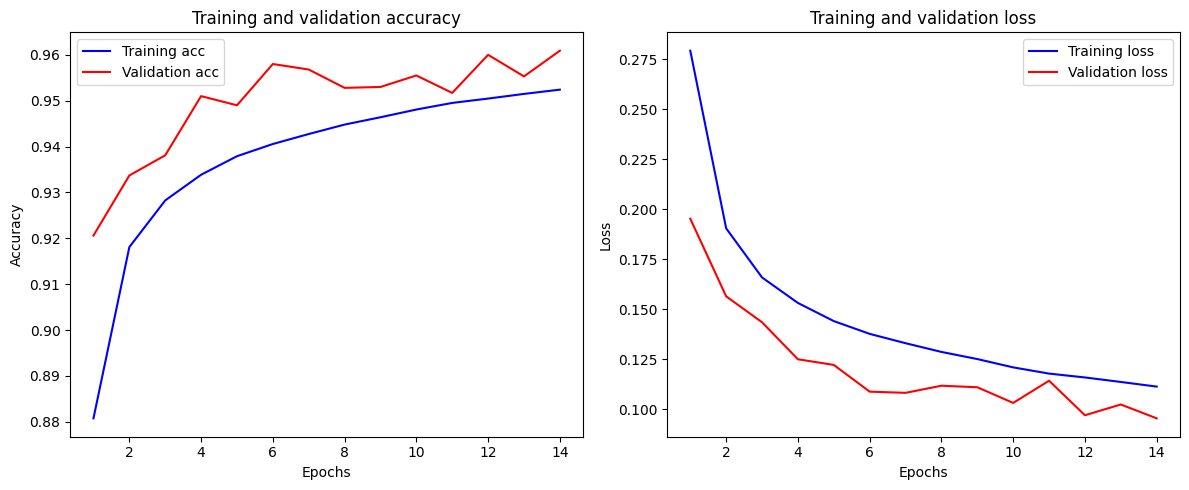

In [ ]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Create two subplots: one for accuracy and one for loss
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Ensures that the subplots don't overlap
plt.show()

Evaluating model with batch norm & sep conv techniques

In [ ]:
my_model = tf.keras.models.load_model("model2.h5")
my_model.evaluate(tensr_4_DM[990000:1000000, :, :, :], class_label[990000:1000000])

313/313 [==============================] - 2s 6ms/step - loss: 0.0953 - binary_accuracy: 0.9601


[0.09527774900197983, 0.960099995136261]

313/313 [==============================] - 2s 4ms/step


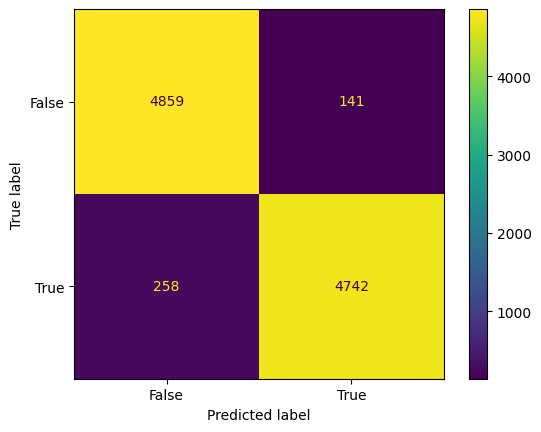

In [ ]:
# Make predictions and create a confusion matrix
actual = class_label[990000:1000000]
seq_predictions = my_model.predict(tensr_4_DM[990000:1000000, :, :])
seq_predictions = np.transpose(seq_predictions)[0]
seq_predictions = list(map(lambda x: 0 if x < 0.5 else 1, seq_predictions))

# Calculate the confusion matrix using sklearn metrics
confusion_matrix = sklearn_metrics.confusion_matrix(actual, seq_predictions)

# Display the confusion matrix
cm_display = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

Model with ReduceLROnPlateau technique

In [ ]:
input_tensor = tf.keras.Input(shape=(4, 4, 2))
layer1 = tf.keras.layers.Conv2D(64, 1)(input_tensor)
layer1 = tf.keras.layers.LeakyReLU()(layer1)
layer2 = tf.keras.layers.Conv2D(64, 1)(layer1)
layer2 = tf.keras.layers.LeakyReLU()(layer2)
layer3 = tf.keras.layers.Conv2D(128, 2)(layer2)
layer3 = tf.keras.layers.LeakyReLU()(layer3)
layer4 = tf.keras.layers.Conv2D(128, 1)(layer3)
layer4 = tf.keras.layers.LeakyReLU()(layer4)
layer5 = tf.keras.layers.Conv2D(128, 2)(layer4)
layer5 = tf.keras.layers.LeakyReLU()(layer5)
layer6 = tf.keras.layers.Conv2D(256, 1)(layer5)
layer6 = tf.keras.layers.LeakyReLU()(layer6)
layer7 = tf.keras.layers.Conv2D(256, 2)(layer6)
layer7 = tf.keras.layers.LeakyReLU()(layer7)
layer8 = tf.keras.layers.Conv2D(512, 1)(layer7)
layer8 = tf.keras.layers.LeakyReLU()(layer8)
layer9 = tf.keras.layers.Conv2D(512, 1)(layer8)
layer9 = tf.keras.layers.LeakyReLU()(layer9)
layer10 = tf.keras.layers.Conv2D(512, 1)(layer9)
layer10 = tf.keras.layers.LeakyReLU()(layer10)
top1 = tf.keras.layers.Flatten()(layer10)
top1 = tf.keras.layers.Dense(512)(top1)
top1 = tf.keras.layers.LeakyReLU()(top1)

top2 = tf.keras.layers.Dense(1)(top1)
top2 = tf.keras.layers.Activation('sigmoid')(top2)

model3 = tf.keras.models.Model(input_tensor, top2)
model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 4, 2)]         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 4, 4, 64)          192       
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 4, 4, 64)          0         
                                                                 
 conv2d_25 (Conv2D)          (None, 4, 4, 64)          4160      
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 4, 4, 64)          0         
                                                                 
 conv2d_26 (Conv2D)          (None, 3, 3, 128)         32896     
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 3, 3, 128)         0   

Compiling and training model with ReduceLROnPlateau technique

In [ ]:
model3.compile(
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 0.01, momentum = 0.9,
    ),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = tf.keras.metrics.binary_accuracy)
callback_list = [
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath = 'model3.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 )
]
history = model3.fit(
    tensr_4_DM[:980000, :, :, :],
    class_label[:980000],
    batch_size = 125,
    epochs = 8,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :], class_label[980000:990000]),
)

Epoch 1/8
7840/7840 [==============================] - 49s 6ms/step - loss: 0.3444 - binary_accuracy: 0.8297 - val_loss: 0.2399 - val_binary_accuracy: 0.8867
Epoch 2/8
  15/7840 [..............................] - ETA: 58s - loss: 0.2710 - binary_accuracy: 0.8741 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7840/7840 [==============================] - 47s 6ms/step - loss: 0.2196 - binary_accuracy: 0.9008 - val_loss: 0.1880 - val_binary_accuracy: 0.9164
Epoch 3/8
7840/7840 [==============================] - 47s 6ms/step - loss: 0.1650 - binary_accuracy: 0.9272 - val_loss: 0.1397 - val_binary_accuracy: 0.9370
Epoch 4/8
7840/7840 [==============================] - 47s 6ms/step - loss: 0.1341 - binary_accuracy: 0.9414 - val_loss: 0.1225 - val_binary_accuracy: 0.9463
Epoch 5/8
7840/7840 [==============================] - 47s 6ms/step - loss: 0.1192 - binary_accuracy: 0.9482 - val_loss: 0.1124 - val_binary_accuracy: 0.9507
Epoch 6/8
7840/7840 [==============================] - 47s 6ms/step - loss: 0.1095 - binary_accuracy: 0.9526 - val_loss: 0.1021 - val_binary_accuracy: 0.9551
Epoch 7/8
7840/7840 [==============================] - 47s 6ms/step - loss: 0.1029 - binary_accuracy: 0.9555 - val_loss: 0.0933 - val_binary_accuracy: 0.9590
Epoch 8/8
7840/7840 [==============================] - 48s 6ms

First manual learning rate reduction

In [ ]:
model3.compile(
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 0.001, momentum = 0.9,
    ),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = tf.keras.metrics.binary_accuracy)
history1 = model3.fit(
    tensr_4_DM[:980000, :, :, :],
    class_label[:980000],
    batch_size = 125,
    epochs = 4,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :], class_label[980000:990000]),
)

Epoch 1/4
7840/7840 [==============================] - 49s 6ms/step - loss: 0.0485 - binary_accuracy: 0.9801 - val_loss: 0.0557 - val_binary_accuracy: 0.9763
Epoch 2/4
7840/7840 [==============================] - 47s 6ms/step - loss: 0.0428 - binary_accuracy: 0.9822 - val_loss: 0.0587 - val_binary_accuracy: 0.9748
Epoch 3/4
7840/7840 [==============================] - 47s 6ms/step - loss: 0.0408 - binary_accuracy: 0.9829 - val_loss: 0.0580 - val_binary_accuracy: 0.9736
Epoch 4/4
7840/7840 [==============================] - 46s 6ms/step - loss: 0.0389 - binary_accuracy: 0.9837 - val_loss: 0.0592 - val_binary_accuracy: 0.9744


Second manual learning rate reduction

In [ ]:
model3.compile(
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 0.0001, momentum = 0.9,
    ),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = tf.keras.metrics.binary_accuracy)
history2 = model3.fit(
    tensr_4_DM[:980000, :, :, :],
    class_label[:980000],
    batch_size = 125,
    epochs = 2,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :], class_label[980000:990000]),
)

Epoch 1/2
7840/7840 [==============================] - 50s 6ms/step - loss: 0.0294 - binary_accuracy: 0.9886 - val_loss: 0.0479 - val_binary_accuracy: 0.9788
Epoch 2/2
7840/7840 [==============================] - 47s 6ms/step - loss: 0.0283 - binary_accuracy: 0.9889 - val_loss: 0.0481 - val_binary_accuracy: 0.9787


Depicting performanc of model with ReduceLROnPlateau technique

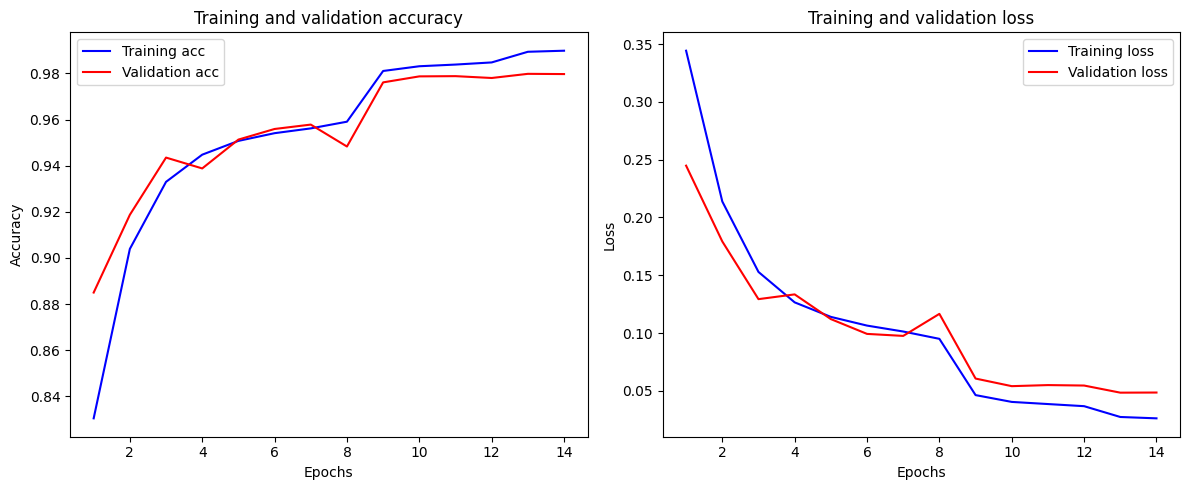

In [ ]:
history_dict1 = history.history
history_dict2 = history1.history
history_dict3 = history2.history
acc = history_dict1['binary_accuracy'] + history_dict2['binary_accuracy'] + history_dict3['binary_accuracy']
val_acc = history_dict1['val_binary_accuracy'] + history_dict2['val_binary_accuracy'] + history_dict3['val_binary_accuracy']
loss = history_dict1['loss'] + history_dict2['loss'] + history_dict3['loss']
val_loss = history_dict1['val_loss'] + history_dict2['val_loss'] + history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# Create two subplots: one for accuracy and one for loss
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Ensures that the subplots don't overlap
plt.show()

Evaluating model with ReduceLROnPlateau technique

In [ ]:
my_model = tf.keras.models.load_model("model3.h5")
my_model.evaluate(tensr_4_DM[990000:1000000, :, :, :], class_label[990000:1000000])

313/313 [==============================] - 1s 3ms/step - loss: 0.0475 - binary_accuracy: 0.9788


[0.047484610229730606, 0.9787999987602234]

313/313 [==============================] - 1s 2ms/step


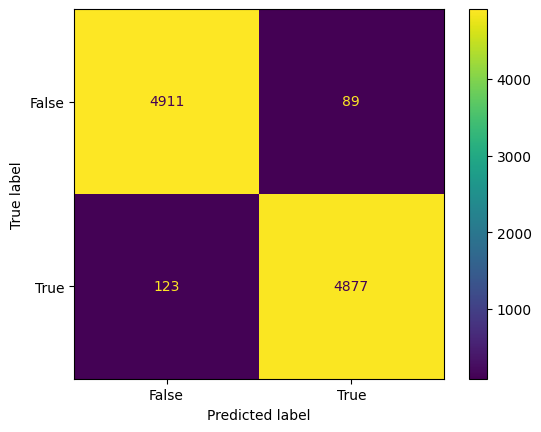

In [ ]:
# Make predictions and create a confusion matrix
actual = class_label[990000:1000000]
seq_predictions = my_model.predict(tensr_4_DM[990000:1000000, :, :])
seq_predictions = np.transpose(seq_predictions)[0]
seq_predictions = list(map(lambda x: 0 if x < 0.5 else 1, seq_predictions))

# Calculate the confusion matrix using sklearn metrics
confusion_matrix = sklearn_metrics.confusion_matrix(actual, seq_predictions)

# Display the confusion matrix
cm_display = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

Branched convolutional model with ReduceLROnPlateau technique

In [ ]:
input_tensor = tf.keras.Input(shape=(4, 4, 2))
layer1 = tf.keras.layers.Conv2D(64, 1)(input_tensor)
layer1 = tf.keras.layers.LeakyReLU()(layer1)
layer2 = tf.keras.layers.Conv2D(64, 1)(layer1)
layer2 = tf.keras.layers.LeakyReLU()(layer2)
branch_a = tf.keras.layers.Conv2D(256, 4)(layer2)
branch_a = tf.keras.layers.LeakyReLU()(branch_a)
branch_a = tf.keras.layers.Conv2D(128, 1)(branch_a)
branch_a = tf.keras.layers.LeakyReLU()(branch_a)
branch_b = tf.keras.layers.Conv2D(192, 3)(layer2)
branch_b = tf.keras.layers.LeakyReLU()(branch_b)
layer3 = tf.keras.layers.Conv2D(128, 2)(layer2)
layer3 = tf.keras.layers.LeakyReLU()(layer3)
layer4 = tf.keras.layers.Conv2D(128, 1)(layer3)
layer4 = tf.keras.layers.LeakyReLU()(layer4)
branch_c = tf.keras.layers.Conv2D(96, 3)(layer4)
branch_c = tf.keras.layers.LeakyReLU()(branch_c)
layer5 = tf.keras.layers.Conv2D(128, 2)(layer4)
layer5 = tf.keras.layers.LeakyReLU()(layer5)
layer5 = tf.keras.layers.concatenate([layer5, branch_b], axis=-1)
layer6 = tf.keras.layers.Conv2D(256, 1)(layer5)
layer6 = tf.keras.layers.LeakyReLU()(layer6)
layer7 = tf.keras.layers.Conv2D(256, 2)(layer6)
layer7 = tf.keras.layers.LeakyReLU()(layer7)
layer7 = tf.keras.layers.concatenate([layer7, branch_a], axis=-1)
layer8 = tf.keras.layers.Conv2D(512, 1)(layer7)
layer8 = tf.keras.layers.LeakyReLU()(layer8)
layer8 = tf.keras.layers.concatenate([layer8, branch_c], axis=-1)
layer9 = tf.keras.layers.Conv2D(512, 1)(layer8)
layer9 = tf.keras.layers.LeakyReLU()(layer9)
layer10 = tf.keras.layers.Conv2D(512, 1)(layer9)
layer10 = tf.keras.layers.LeakyReLU()(layer10)
top1 = tf.keras.layers.Flatten()(layer10)
top1 = tf.keras.layers.Dense(512)(top1)
top1 = tf.keras.layers.LeakyReLU()(top1)

top2 = tf.keras.layers.Dense(1)(top1)
top2 = tf.keras.layers.Activation('sigmoid')(top2)

hybrid_model1 = tf.keras.models.Model(input_tensor, top2)
hybrid_model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 4, 4, 2)]            0         []                            
                                                                                                  
 conv2d_34 (Conv2D)          (None, 4, 4, 64)             192       ['input_5[0][0]']             
                                                                                                  
 leaky_re_lu_50 (LeakyReLU)  (None, 4, 4, 64)             0         ['conv2d_34[0][0]']           
                                                                                                  
 conv2d_35 (Conv2D)          (None, 4, 4, 64)             4160      ['leaky_re_lu_50[0][0]']      
                                                                                            

Compiling and training branched convolutional model with ReduceLROnPlateau technique

In [ ]:
hybrid_model1.compile(
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 0.01, momentum = 0.9,
    ),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = tf.keras.metrics.binary_accuracy)
callback_list = [
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath = 'hybrid_model1.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 )
]
history = hybrid_model1.fit(
    tensr_4_DM[:980000, :, :, :],
    class_label[:980000],
    batch_size = 125,
    epochs = 8,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :], class_label[980000:990000]),
)

Epoch 1/8
7840/7840 [==============================] - 62s 8ms/step - loss: 0.2989 - binary_accuracy: 0.8584 - val_loss: 0.1632 - val_binary_accuracy: 0.9291
Epoch 2/8
   8/7840 [..............................] - ETA: 1:03 - loss: 0.1436 - binary_accuracy: 0.9430

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7840/7840 [==============================] - 57s 7ms/step - loss: 0.1439 - binary_accuracy: 0.9370 - val_loss: 0.1537 - val_binary_accuracy: 0.9346
Epoch 3/8
7840/7840 [==============================] - 58s 7ms/step - loss: 0.1140 - binary_accuracy: 0.9503 - val_loss: 0.1185 - val_binary_accuracy: 0.9488
Epoch 4/8
7840/7840 [==============================] - 58s 7ms/step - loss: 0.0992 - binary_accuracy: 0.9568 - val_loss: 0.0949 - val_binary_accuracy: 0.9597
Epoch 5/8
7840/7840 [==============================] - 58s 7ms/step - loss: 0.0906 - binary_accuracy: 0.9610 - val_loss: 0.0903 - val_binary_accuracy: 0.9605
Epoch 6/8
7840/7840 [==============================] - 57s 7ms/step - loss: 0.0846 - binary_accuracy: 0.9635 - val_loss: 0.0928 - val_binary_accuracy: 0.9594
Epoch 7/8
7840/7840 [==============================] - 58s 7ms/step - loss: 0.0796 - binary_accuracy: 0.9658 - val_loss: 0.0910 - val_binary_accuracy: 0.9611
Epoch 8/8
7840/7840 [==============================] - 58s 7ms

First manual learning rate reduction

In [ ]:
hybrid_model1.compile(
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 0.001, momentum = 0.9,
    ),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = tf.keras.metrics.binary_accuracy)
history1 = hybrid_model1.fit(
    tensr_4_DM[:980000, :, :, :],
    class_label[:980000],
    batch_size = 125,
    epochs = 4,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :], class_label[980000:990000]),
)

Epoch 1/4
7840/7840 [==============================] - 61s 7ms/step - loss: 0.0336 - binary_accuracy: 0.9870 - val_loss: 0.0455 - val_binary_accuracy: 0.9810
Epoch 2/4
7840/7840 [==============================] - 58s 7ms/step - loss: 0.0281 - binary_accuracy: 0.9886 - val_loss: 0.0447 - val_binary_accuracy: 0.9810
Epoch 3/4
7840/7840 [==============================] - 57s 7ms/step - loss: 0.0264 - binary_accuracy: 0.9892 - val_loss: 0.0435 - val_binary_accuracy: 0.9818
Epoch 4/4
7840/7840 [==============================] - 58s 7ms/step - loss: 0.0251 - binary_accuracy: 0.9897 - val_loss: 0.0465 - val_binary_accuracy: 0.9816


Second manual learning rate reduction

In [ ]:
hybrid_model1.compile(
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 0.0001, momentum = 0.9,
    ),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = tf.keras.metrics.binary_accuracy)
history2 = hybrid_model1.fit(
    tensr_4_DM[:980000, :, :, :],
    class_label[:980000],
    batch_size = 125,
    epochs = 2,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :], class_label[980000:990000]),
)

Epoch 1/2
7840/7840 [==============================] - 61s 7ms/step - loss: 0.0175 - binary_accuracy: 0.9937 - val_loss: 0.0352 - val_binary_accuracy: 0.9844
Epoch 2/2
7840/7840 [==============================] - 59s 7ms/step - loss: 0.0167 - binary_accuracy: 0.9940 - val_loss: 0.0362 - val_binary_accuracy: 0.9843


Depicting performanc of branched convolutional model with ReduceLROnPlateau technique

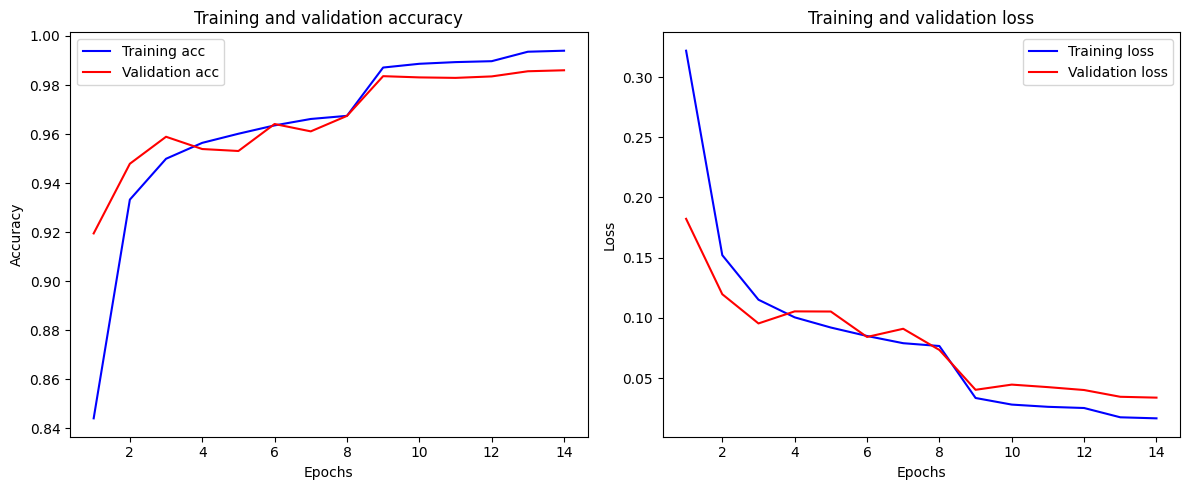

In [ ]:
history_dict1 = history.history
history_dict2 = history1.history
history_dict3 = history2.history
acc = history_dict1['binary_accuracy'] + history_dict2['binary_accuracy'] + history_dict3['binary_accuracy']
val_acc = history_dict1['val_binary_accuracy'] + history_dict2['val_binary_accuracy'] + history_dict3['val_binary_accuracy']
loss = history_dict1['loss'] + history_dict2['loss'] + history_dict3['loss']
val_loss = history_dict1['val_loss'] + history_dict2['val_loss'] + history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# Create two subplots: one for accuracy and one for loss
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Ensures that the subplots don't overlap
plt.show()

Evaluating branched convolutional model with ReduceLROnPlateau technique

In [ ]:
my_model = tf.keras.models.load_model("hybrid_model1.h5")
my_model.evaluate(tensr_4_DM[990000:1000000, :, :, :], class_label[990000:1000000])

313/313 [==============================] - 1s 4ms/step - loss: 0.0351 - binary_accuracy: 0.9856


[0.03512711077928543, 0.9855999946594238]

313/313 [==============================] - 1s 2ms/step


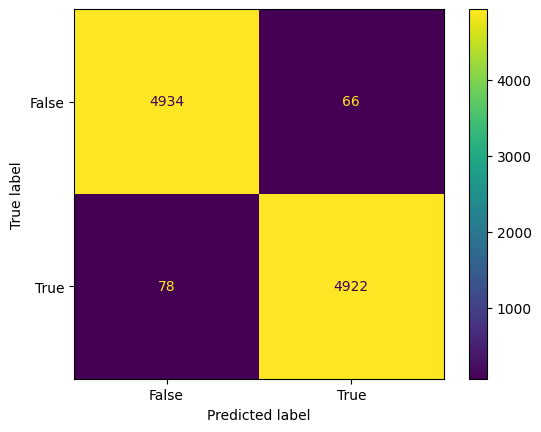

In [ ]:
# Make predictions and create a confusion matrix
actual = class_label[990000:1000000]
seq_predictions = my_model.predict(tensr_4_DM[990000:1000000, :, :])
seq_predictions = np.transpose(seq_predictions)[0]
seq_predictions = list(map(lambda x: 0 if x < 0.5 else 1, seq_predictions))

# Calculate the confusion matrix using sklearn metrics
confusion_matrix = sklearn_metrics.confusion_matrix(actual, seq_predictions)

# Display the confusion matrix
cm_display = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

Model with batch norm & sep conv & ReduceLROnPlateau techniques

In [ ]:
input_tensor = tf.keras.Input(shape=(4, 4, 2))
layer1 = tf.keras.layers.SeparableConv2D(64, 1)(input_tensor)
layer1 = tf.keras.layers.BatchNormalization()(layer1)
layer1 = tf.keras.layers.LeakyReLU()(layer1)
layer2 = tf.keras.layers.SeparableConv2D(64, 1)(layer1)
layer2 = tf.keras.layers.BatchNormalization()(layer2)
layer2 = tf.keras.layers.LeakyReLU()(layer2)
layer3 = tf.keras.layers.SeparableConv2D(128, 2)(layer2)
layer3 = tf.keras.layers.BatchNormalization()(layer3)
layer3 = tf.keras.layers.LeakyReLU()(layer3)
layer4 = tf.keras.layers.SeparableConv2D(128, 1)(layer3)
layer4 = tf.keras.layers.BatchNormalization()(layer4)
layer4 = tf.keras.layers.LeakyReLU()(layer4)
layer5 = tf.keras.layers.SeparableConv2D(128, 2)(layer4)
layer5 = tf.keras.layers.BatchNormalization()(layer5)
layer5 = tf.keras.layers.LeakyReLU()(layer5)
layer6 = tf.keras.layers.SeparableConv2D(256, 1)(layer5)
layer6 = tf.keras.layers.BatchNormalization()(layer6)
layer6 = tf.keras.layers.LeakyReLU()(layer6)
layer7 = tf.keras.layers.SeparableConv2D(256, 2)(layer6)
layer7 = tf.keras.layers.BatchNormalization()(layer7)
layer7 = tf.keras.layers.LeakyReLU()(layer7)
layer8 = tf.keras.layers.SeparableConv2D(512, 1)(layer7)
layer8 = tf.keras.layers.BatchNormalization()(layer8)
layer8 = tf.keras.layers.LeakyReLU()(layer8)
layer9 = tf.keras.layers.SeparableConv2D(512, 1)(layer8)
layer9 = tf.keras.layers.BatchNormalization()(layer9)
layer9 = tf.keras.layers.LeakyReLU()(layer9)
layer10 = tf.keras.layers.SeparableConv2D(512, 1)(layer9)
layer10 = tf.keras.layers.BatchNormalization()(layer10)
layer10 = tf.keras.layers.LeakyReLU()(layer10)
top1 = tf.keras.layers.Flatten()(layer10)
top1 = tf.keras.layers.Dense(512)(top1)
top1 = tf.keras.layers.BatchNormalization()(top1)
top1 = tf.keras.layers.LeakyReLU()(top1)

top2 = tf.keras.layers.Dense(1)(top1)
top2 = tf.keras.layers.BatchNormalization()(top2)
top2 = tf.keras.layers.Activation('sigmoid')(top2)

hybrid_model2 = tf.keras.models.Model(input_tensor, top2)
hybrid_model2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 4, 4, 2)]         0         
                                                                 
 separable_conv2d_10 (Separ  (None, 4, 4, 64)          194       
 ableConv2D)                                                     
                                                                 
 batch_normalization_12 (Ba  (None, 4, 4, 64)          256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_65 (LeakyReLU)  (None, 4, 4, 64)          0         
                                                                 
 separable_conv2d_11 (Separ  (None, 4, 4, 64)          4224      
 ableConv2D)                                                     
                                                           

Compiling and training model with batch norm & sep conv & ReduceLROnPlateau techniques

In [ ]:
hybrid_model2.compile(
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 0.01, momentum = 0.9,
    ),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = tf.keras.metrics.binary_accuracy)
callback_list = [
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath = 'hybrid_model2.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 )
]
history = hybrid_model2.fit(
    tensr_4_DM[:980000, :, :, :],
    class_label[:980000],
    batch_size = 125,
    epochs = 8,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :], class_label[980000:990000]),
)

Epoch 1/8
7840/7840 [==============================] - 87s 10ms/step - loss: 0.2460 - binary_accuracy: 0.8900 - val_loss: 0.1815 - val_binary_accuracy: 0.9184
Epoch 2/8
   6/7840 [..............................] - ETA: 1:19 - loss: 0.1953 - binary_accuracy: 0.9093

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7840/7840 [==============================] - 82s 10ms/step - loss: 0.1744 - binary_accuracy: 0.9232 - val_loss: 0.1541 - val_binary_accuracy: 0.9320
Epoch 3/8
7840/7840 [==============================] - 82s 10ms/step - loss: 0.1543 - binary_accuracy: 0.9327 - val_loss: 0.1450 - val_binary_accuracy: 0.9385
Epoch 4/8
7840/7840 [==============================] - 81s 10ms/step - loss: 0.1431 - binary_accuracy: 0.9377 - val_loss: 0.1232 - val_binary_accuracy: 0.9455
Epoch 5/8
7840/7840 [==============================] - 81s 10ms/step - loss: 0.1351 - binary_accuracy: 0.9409 - val_loss: 0.1338 - val_binary_accuracy: 0.9403
Epoch 6/8
7840/7840 [==============================] - 82s 11ms/step - loss: 0.1292 - binary_accuracy: 0.9439 - val_loss: 0.1050 - val_binary_accuracy: 0.9560
Epoch 7/8
7840/7840 [==============================] - 81s 10ms/step - loss: 0.1252 - binary_accuracy: 0.9456 - val_loss: 0.1090 - val_binary_accuracy: 0.9541
Epoch 8/8
7840/7840 [==============================] - 8

First manual learning rate reduction

In [ ]:
hybrid_model2.compile(
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 0.001, momentum = 0.9,
    ),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = tf.keras.metrics.binary_accuracy)
history1 = hybrid_model2.fit(
    tensr_4_DM[:980000, :, :, :],
    class_label[:980000],
    batch_size = 125,
    epochs = 4,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :], class_label[980000:990000]),
)

Epoch 1/4
7840/7840 [==============================] - 85s 10ms/step - loss: 0.0930 - binary_accuracy: 0.9607 - val_loss: 0.0773 - val_binary_accuracy: 0.9671
Epoch 2/4
7840/7840 [==============================] - 80s 10ms/step - loss: 0.0892 - binary_accuracy: 0.9622 - val_loss: 0.0750 - val_binary_accuracy: 0.9685
Epoch 3/4
7840/7840 [==============================] - 80s 10ms/step - loss: 0.0878 - binary_accuracy: 0.9628 - val_loss: 0.0732 - val_binary_accuracy: 0.9701
Epoch 4/4
7840/7840 [==============================] - 81s 10ms/step - loss: 0.0871 - binary_accuracy: 0.9629 - val_loss: 0.0718 - val_binary_accuracy: 0.9711


Second manual learning rate reduction

In [ ]:
hybrid_model2.compile(
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 0.0001, momentum = 0.9,
    ),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = tf.keras.metrics.binary_accuracy)
history2 = hybrid_model2.fit(
    tensr_4_DM[:980000, :, :, :],
    class_label[:980000],
    batch_size = 125,
    epochs = 2,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :], class_label[980000:990000]),
)

Epoch 1/2
7840/7840 [==============================] - 88s 11ms/step - loss: 0.0818 - binary_accuracy: 0.9654 - val_loss: 0.0677 - val_binary_accuracy: 0.9715
Epoch 2/2
7840/7840 [==============================] - 80s 10ms/step - loss: 0.0818 - binary_accuracy: 0.9654 - val_loss: 0.0672 - val_binary_accuracy: 0.9719


Depicting performanc of model with batch norm & sep conv & ReduceLROnPlateau techniques

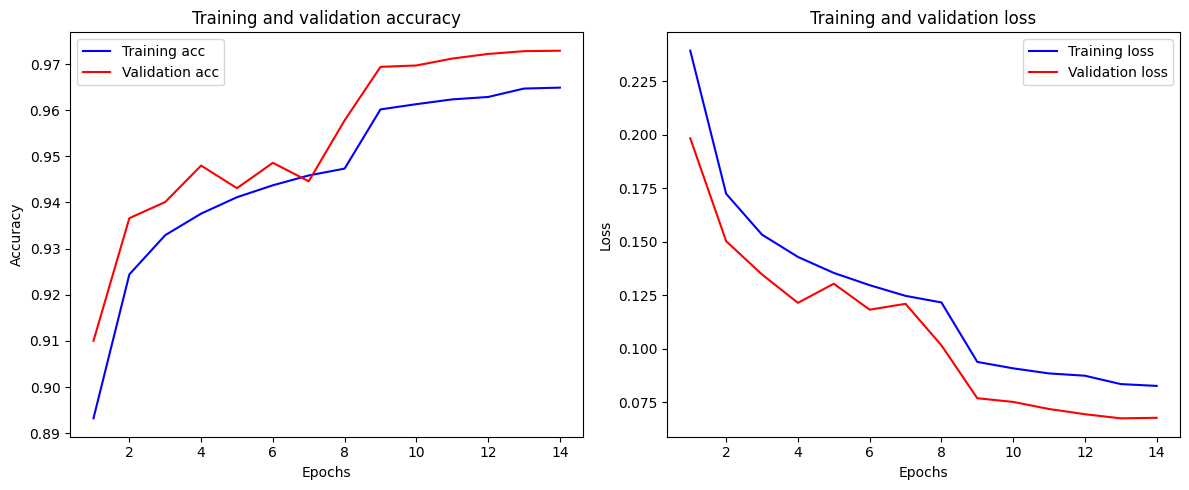

In [ ]:
history_dict1 = history.history
history_dict2 = history1.history
history_dict3 = history2.history
acc = history_dict1['binary_accuracy'] + history_dict2['binary_accuracy'] + history_dict3['binary_accuracy']
val_acc = history_dict1['val_binary_accuracy'] + history_dict2['val_binary_accuracy'] + history_dict3['val_binary_accuracy']
loss = history_dict1['loss'] + history_dict2['loss'] + history_dict3['loss']
val_loss = history_dict1['val_loss'] + history_dict2['val_loss'] + history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# Create two subplots: one for accuracy and one for loss
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Ensures that the subplots don't overlap
plt.show()

Evaluating model with batch norm & sep conv & ReduceLROnPlateau techniques

In [ ]:
my_model = tf.keras.models.load_model("hybrid_model2.h5")
my_model.evaluate(tensr_4_DM[990000:1000000, :, :, :], class_label[990000:1000000])

313/313 [==============================] - 2s 5ms/step - loss: 0.0668 - binary_accuracy: 0.9723


[0.06683140993118286, 0.9722999930381775]

313/313 [==============================] - 1s 3ms/step


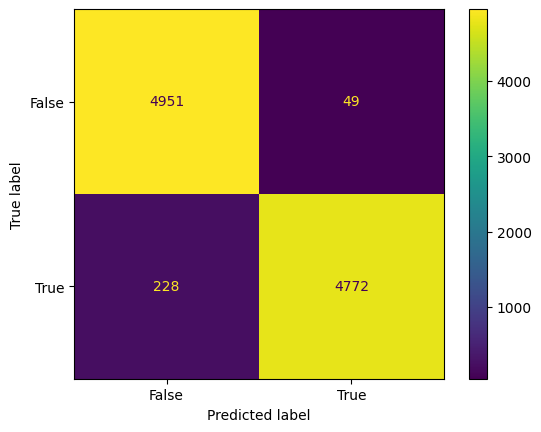

In [ ]:
# Make predictions and create a confusion matrix
actual = class_label[990000:1000000]
seq_predictions = my_model.predict(tensr_4_DM[990000:1000000, :, :])
seq_predictions = np.transpose(seq_predictions)[0]
seq_predictions = list(map(lambda x: 0 if x < 0.5 else 1, seq_predictions))

# Calculate the confusion matrix using sklearn metrics
confusion_matrix = sklearn_metrics.confusion_matrix(actual, seq_predictions)

# Display the confusion matrix
cm_display = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

Branched convolutional model with batch norm & sep conv techniques

In [ ]:
input_tensor = tf.keras.Input(shape=(4, 4, 2))
layer1 = tf.keras.layers.SeparableConv2D(64, 1)(input_tensor)
layer1 = tf.keras.layers.BatchNormalization()(layer1)
layer1 = tf.keras.layers.LeakyReLU()(layer1)
layer2 = tf.keras.layers.SeparableConv2D(64, 1)(layer1)
layer2 = tf.keras.layers.BatchNormalization()(layer2)
layer2 = tf.keras.layers.LeakyReLU()(layer2)
branch_a = tf.keras.layers.SeparableConv2D(256, 4)(layer2)
branch_a = tf.keras.layers.BatchNormalization()(branch_a)
branch_a = tf.keras.layers.LeakyReLU()(branch_a)
branch_a = tf.keras.layers.SeparableConv2D(128, 1)(branch_a)
branch_a = tf.keras.layers.BatchNormalization()(branch_a)
branch_a = tf.keras.layers.LeakyReLU()(branch_a)
branch_b = tf.keras.layers.SeparableConv2D(192, 3)(layer2)
branch_b = tf.keras.layers.BatchNormalization()(branch_b)
branch_b = tf.keras.layers.LeakyReLU()(branch_b)
layer3 = tf.keras.layers.SeparableConv2D(128, 2)(layer2)
layer3 = tf.keras.layers.BatchNormalization()(layer3)
layer3 = tf.keras.layers.LeakyReLU()(layer3)
layer4 = tf.keras.layers.SeparableConv2D(128, 1)(layer3)
layer4 = tf.keras.layers.BatchNormalization()(layer4)
layer4 = tf.keras.layers.LeakyReLU()(layer4)
branch_c = tf.keras.layers.SeparableConv2D(96, 3)(layer4)
branch_c = tf.keras.layers.BatchNormalization()(branch_c)
branch_c = tf.keras.layers.LeakyReLU()(branch_c)
layer5 = tf.keras.layers.SeparableConv2D(128, 2)(layer4)
layer5 = tf.keras.layers.BatchNormalization()(layer5)
layer5 = tf.keras.layers.LeakyReLU()(layer5)
layer5 = tf.keras.layers.concatenate([layer5, branch_b], axis=-1)
layer6 = tf.keras.layers.SeparableConv2D(256, 1)(layer5)
layer6 = tf.keras.layers.BatchNormalization()(layer6)
layer6 = tf.keras.layers.LeakyReLU()(layer6)
layer7 = tf.keras.layers.SeparableConv2D(256, 2)(layer6)
layer7 = tf.keras.layers.BatchNormalization()(layer7)
layer7 = tf.keras.layers.LeakyReLU()(layer7)
layer7 = tf.keras.layers.concatenate([layer7, branch_a], axis=-1)
layer8 = tf.keras.layers.SeparableConv2D(512, 1)(layer7)
layer8 = tf.keras.layers.BatchNormalization()(layer8)
layer8 = tf.keras.layers.LeakyReLU()(layer8)
layer8 = tf.keras.layers.concatenate([layer8, branch_c], axis=-1)
layer9 = tf.keras.layers.SeparableConv2D(512, 1)(layer8)
layer9 = tf.keras.layers.BatchNormalization()(layer9)
layer9 = tf.keras.layers.LeakyReLU()(layer9)
layer10 = tf.keras.layers.SeparableConv2D(512, 1)(layer9)
layer10 = tf.keras.layers.BatchNormalization()(layer10)
layer10 = tf.keras.layers.LeakyReLU()(layer10)
top1 = tf.keras.layers.Flatten()(layer10)
top1 = tf.keras.layers.Dense(512)(top1)
top1 = tf.keras.layers.BatchNormalization()(top1)
top1 = tf.keras.layers.LeakyReLU()(top1)

top2 = tf.keras.layers.Dense(1)(top1)
top2 = tf.keras.layers.BatchNormalization()(top2)
top2 = tf.keras.layers.Activation('sigmoid')(top2)

hybrid_model3 = tf.keras.models.Model(input_tensor, top2)
hybrid_model3.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 4, 4, 2)]            0         []                            
                                                                                                  
 separable_conv2d_20 (Separ  (None, 4, 4, 64)             194       ['input_7[0][0]']             
 ableConv2D)                                                                                      
                                                                                                  
 batch_normalization_24 (Ba  (None, 4, 4, 64)             256       ['separable_conv2d_20[0][0]'] 
 tchNormalization)                                                                                
                                                                                            

Compiling and training branched convolutional model with batch norm & sep conv techniques

In [ ]:
hybrid_model3.compile(
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 0.01, momentum = 0.9,
    ),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = tf.keras.metrics.binary_accuracy)
callback_list = [
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath = 'hybrid_model3.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 )
]
history = hybrid_model3.fit(
    tensr_4_DM[:980000, :, :, :],
    class_label[:980000],
    batch_size = 125,
    epochs = 14,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :], class_label[980000:990000]),
)

Epoch 1/14
7840/7840 [==============================] - 113s 14ms/step - loss: 0.2238 - binary_accuracy: 0.9010 - val_loss: 0.1821 - val_binary_accuracy: 0.9172
Epoch 2/14
   1/7840 [..............................] - ETA: 2:22 - loss: 0.1016 - binary_accuracy: 0.9600

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7840/7840 [==============================] - 107s 14ms/step - loss: 0.1620 - binary_accuracy: 0.9291 - val_loss: 0.1264 - val_binary_accuracy: 0.9461
Epoch 3/14
7840/7840 [==============================] - 104s 13ms/step - loss: 0.1453 - binary_accuracy: 0.9367 - val_loss: 0.1305 - val_binary_accuracy: 0.9430
Epoch 4/14
7840/7840 [==============================] - 105s 13ms/step - loss: 0.1351 - binary_accuracy: 0.9411 - val_loss: 0.1242 - val_binary_accuracy: 0.9457
Epoch 5/14
7840/7840 [==============================] - 104s 13ms/step - loss: 0.1279 - binary_accuracy: 0.9445 - val_loss: 0.1027 - val_binary_accuracy: 0.9581
Epoch 6/14
7840/7840 [==============================] - 115s 15ms/step - loss: 0.1228 - binary_accuracy: 0.9468 - val_loss: 0.1003 - val_binary_accuracy: 0.9563
Epoch 7/14
7840/7840 [==============================] - 108s 14ms/step - loss: 0.1192 - binary_accuracy: 0.9483 - val_loss: 0.1033 - val_binary_accuracy: 0.9555
Epoch 8/14
7840/7840 [=======================

Depicting performanc of branched convolutional model with batch norm & sep conv techniques

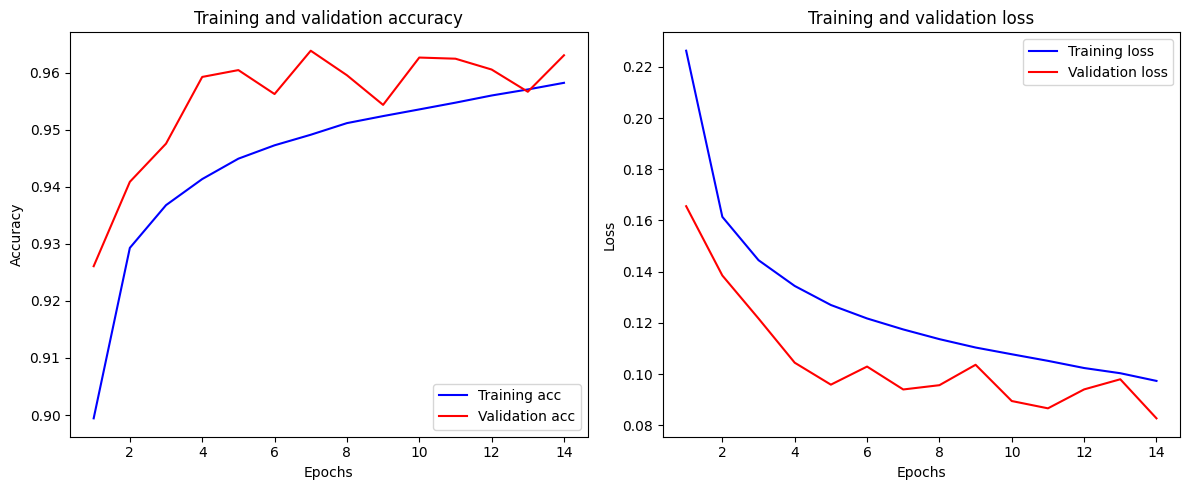

In [ ]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Create two subplots: one for accuracy and one for loss
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Ensures that the subplots don't overlap
plt.show()

Evaluating branched convolutional model with batch norm & sep conv techniques

In [ ]:
my_model = tf.keras.models.load_model("hybrid_model3.h5")
my_model.evaluate(tensr_4_DM[990000:1000000, :, :, :], class_label[990000:1000000])

313/313 [==============================] - 2s 4ms/step - loss: 0.0827 - binary_accuracy: 0.9654


[0.08272644877433777, 0.965399980545044]

313/313 [==============================] - 1s 3ms/step


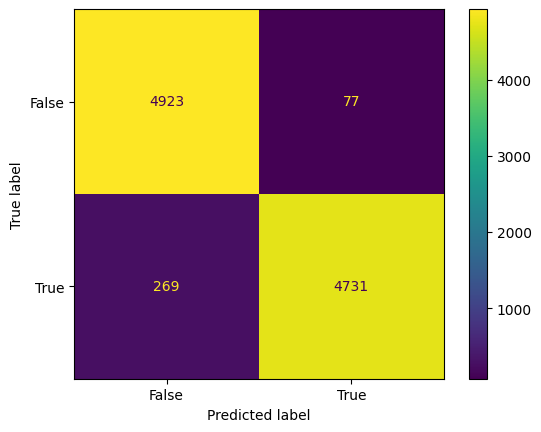

In [ ]:
# Make predictions and create a confusion matrix
actual = class_label[990000:1000000]
seq_predictions = my_model.predict(tensr_4_DM[990000:1000000, :, :])
seq_predictions = np.transpose(seq_predictions)[0]
seq_predictions = list(map(lambda x: 0 if x < 0.5 else 1, seq_predictions))

# Calculate the confusion matrix using sklearn metrics
confusion_matrix = sklearn_metrics.confusion_matrix(actual, seq_predictions)

# Display the confusion matrix
cm_display = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

Branched convolutional model with batch norm & sep conv & ReduceLROnPlateau techniques

In [ ]:
input_tensor = tf.keras.Input(shape=(4, 4, 2))
layer1 = tf.keras.layers.Conv2D(64, 1)(input_tensor)
layer1 = tf.keras.layers.LeakyReLU()(layer1)
layer2 = tf.keras.layers.Conv2D(64, 1)(layer1)
layer2 = tf.keras.layers.LeakyReLU()(layer2)
layer3 = tf.keras.layers.Conv2D(128, 2)(layer2)
layer3 = tf.keras.layers.LeakyReLU()(layer3)
layer4 = tf.keras.layers.Conv2D(128, 1)(layer3)
layer4 = tf.keras.layers.LeakyReLU()(layer4)
layer5 = tf.keras.layers.Conv2D(128, 2)(layer4)
layer5 = tf.keras.layers.LeakyReLU()(layer5)
layer6 = tf.keras.layers.Conv2D(256, 1)(layer5)
layer6 = tf.keras.layers.LeakyReLU()(layer6)
layer7 = tf.keras.layers.Conv2D(256, 2)(layer6)
layer7 = tf.keras.layers.LeakyReLU()(layer7)
layer8 = tf.keras.layers.Conv2D(512, 1)(layer7)
layer8 = tf.keras.layers.LeakyReLU()(layer8)
layer9 = tf.keras.layers.Conv2D(512, 1)(layer8)
layer9 = tf.keras.layers.LeakyReLU()(layer9)
layer10 = tf.keras.layers.Conv2D(512, 1)(layer9)
layer10 = tf.keras.layers.LeakyReLU()(layer10)
top1 = tf.keras.layers.Flatten()(layer10)
top1 = tf.keras.layers.Dense(512)(top1)
top1 = tf.keras.layers.LeakyReLU()(top1)

top2 = tf.keras.layers.Dense(1, name='regression')(top1)

top3 = tf.keras.layers.Dense(1)(top1)
top3 = tf.keras.layers.BatchNormalization()(top3)
top3 = tf.keras.layers.Activation('sigmoid', name='classification')(top3)

model4 = tf.keras.models.Model(input_tensor, [top2, top3])
model4.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 4, 4, 2)]            0         []                            
                                                                                                  
 conv2d_48 (Conv2D)          (None, 4, 4, 64)             192       ['input_8[0][0]']             
                                                                                                  
 leaky_re_lu_91 (LeakyReLU)  (None, 4, 4, 64)             0         ['conv2d_48[0][0]']           
                                                                                                  
 conv2d_49 (Conv2D)          (None, 4, 4, 64)             4160      ['leaky_re_lu_91[0][0]']      
                                                                                            

Compiling and training branched convolutional model with batch norm & sep conv & ReduceLROnPlateau techniques

In [ ]:
model4.compile(
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 0.01, momentum = 0.9,
    ),
    loss = {
        'regression': tf.keras.losses.mse,
        'classification': tf.keras.losses.binary_crossentropy
        },
    metrics = {
        'regression': tf.keras.metrics.mae,
        'classification': tf.keras.metrics.binary_accuracy
        }
)
callback_list = [
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath = 'all.h5',
                     monitor = 'val_loss',
                     save_best_only = True,

history = model4.fit(
    tensr_4_DM[:980000, :, :, :],
    {'regression': reg_label[:980000], 'classification': class_label[:980000]},
    batch_size = 125,
    epochs = 8,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :],
                     {'regression': reg_label[980000:990000], 'classification': class_label[980000:990000]}
                     ),
)

Epoch 1/8
7840/7840 [==============================] - 59s 7ms/step - loss: 0.3332 - regression_loss: 3.1395e-05 - classification_loss: 0.3332 - regression_mean_absolute_error: 0.0042 - classification_binary_accuracy: 0.8474 - val_loss: 0.3137 - val_regression_loss: 2.6583e-05 - val_classification_loss: 0.3137 - val_regression_mean_absolute_error: 0.0040 - val_classification_binary_accuracy: 0.8520
Epoch 2/8
7840/7840 [==============================] - 56s 7ms/step - loss: 0.2574 - regression_loss: 3.6211e-05 - classification_loss: 0.2573 - regression_mean_absolute_error: 0.0046 - classification_binary_accuracy: 0.8834 - val_loss: 0.2568 - val_regression_loss: 4.7100e-05 - val_classification_loss: 0.2567 - val_regression_mean_absolute_error: 0.0053 - val_classification_binary_accuracy: 0.8887
Epoch 3/8
7840/7840 [==============================] - 58s 7ms/step - loss: 0.2073 - regression_loss: 5.7644e-05 - classification_loss: 0.2073 - regression_mean_absolute_error: 0.0058 - classifica

First manual learning rate reduction

In [ ]:
model4.compile(
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=0.001, momentum=0.9,
    ),
    loss = {
        'regression': tf.keras.losses.mse,
        'classification': tf.keras.losses.binary_crossentropy
        },
    metrics = {
        'regression': tf.keras.metrics.mae,
        'classification': tf.keras.metrics.binary_accuracy
        }
)

history1 = model4.fit(
    tensr_4_DM[:980000, :, :, :],
    {'regression': reg_label[:980000], 'classification': class_label[:980000]},
    batch_size = 125,
    epochs = 4,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :],
                     {'regression': reg_label[980000:990000], 'classification': class_label[980000:990000]}
                     ),
)

Second manual learning rate reduction

In [ ]:
model4.compile(
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=0.0001, momentum=0.9,
    ),
    loss = {
        'regression': tf.keras.losses.mse,
        'classification': tf.keras.losses.binary_crossentropy
        },
    metrics = {
        'regression': tf.keras.metrics.mae,
        'classification': tf.keras.metrics.binary_accuracy
        }
)

history2 = model4.fit(
    tensr_4_DM[:980000, :, :, :],
    {'regression': reg_label[:980000], 'classification': class_label[:980000]},
    batch_size = 125,
    epochs = 2,
    callbacks = callback_list,
    validation_data = (tensr_4_DM[980000:990000, :, :, :],
                     {'regression': reg_label[980000:990000], 'classification': class_label[980000:990000]}
                     ),
)

Depicting performanc of branched convolutional model with batch norm & sep conv & ReduceLROnPlateau techniques

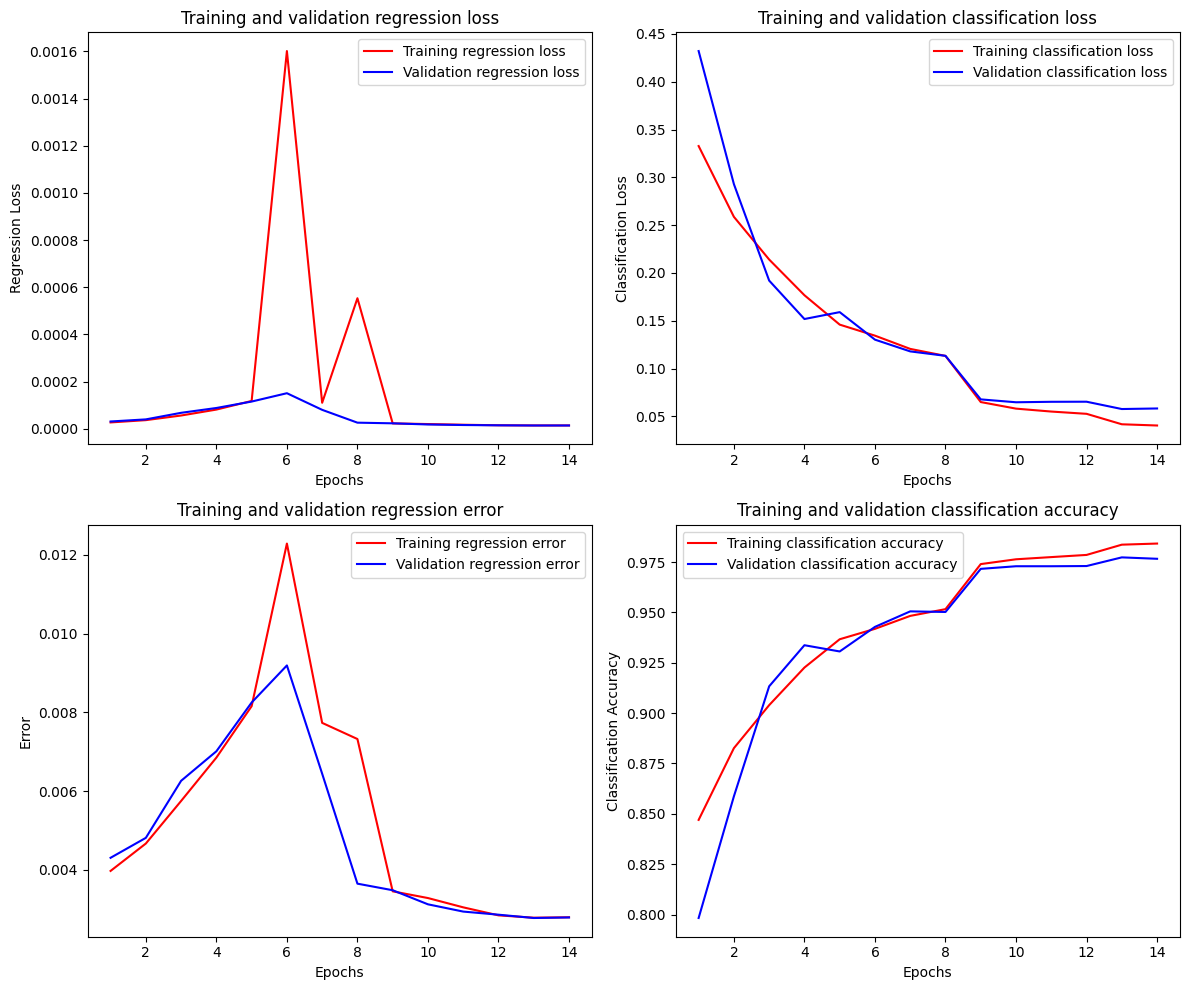

In [ ]:
history_dict1 = history.history
history_dict2 = history1.history
history_dict3 = history2.history

# Calculate the total loss and accuracy values
reg_loss = history_dict1['regression_loss'] + history_dict2['regression_loss'] + history_dict3['regression_loss']
val_reg_loss = history_dict1['val_regression_loss'] + history_dict2['val_regression_loss'] + history_dict3['val_regression_loss']
class_loss = history_dict1['classification_loss'] + history_dict2['classification_loss'] + history_dict3['classification_loss']
val_class_loss = history_dict1['val_classification_loss'] + history_dict2['val_classification_loss'] + history_dict3['val_classification_loss']
error_values = history_dict1['regression_mean_absolute_error'] + history_dict2['regression_mean_absolute_error'] + history_dict3['regression_mean_absolute_error']
val_error_values = history_dict1['val_regression_mean_absolute_error'] + history_dict2['val_regression_mean_absolute_error'] + history_dict3['val_regression_mean_absolute_error']
acc_values = history_dict1['classification_binary_accuracy'] + history_dict2['classification_binary_accuracy'] + history_dict3['classification_binary_accuracy']
val_acc_values = history_dict1['val_classification_binary_accuracy'] + history_dict2['val_classification_binary_accuracy'] + history_dict3['val_classification_binary_accuracy']

epochs = range(1, len(reg_loss) + 1)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot regression loss
axes[0, 0].plot(epochs, reg_loss, 'r', label='Training regression loss')
axes[0, 0].plot(epochs, val_reg_loss, 'b', label='Validation regression loss')
axes[0, 0].set_title('Training and validation regression loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Regression Loss')
axes[0, 0].legend()

# Plot classification loss
axes[0, 1].plot(epochs, class_loss, 'r', label='Training classification loss')
axes[0, 1].plot(epochs, val_class_loss, 'b', label='Validation classification loss')
axes[0, 1].set_title('Training and validation classification loss')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Classification Loss')
axes[0, 1].legend()

# Plot regression error
axes[1, 0].plot(epochs, error_values, 'r', label='Training regression error')
axes[1, 0].plot(epochs, val_error_values, 'b', label='Validation regression error')
axes[1, 0].set_title('Training and validation regression error')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Error')
axes[1, 0].legend()

# Plot classification accuracy
axes[1, 1].plot(epochs, acc_values, 'r', label='Training classification accuracy')
axes[1, 1].plot(epochs, val_acc_values, 'b', label='Validation classification accuracy')
axes[1, 1].set_title('Training and validation classification accuracy')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Classification Accuracy')
axes[1, 1].legend()

plt.tight_layout()  # Ensures that the subplots don't overlap
plt.show()

Evaluating branched convolutional model with batch norm & sep conv & ReduceLROnPlateau techniques

In [ ]:
my_model = tf.keras.models.load_model("hybrid_model3.h5")
my_model.evaluate(tensr_4_DM[990000:1000000, :, :, :], {'regression': reg_label[990000:1000000], 'classification': class_label[990000:1000000]})

313/313 [==============================] - 1s 4ms/step - loss: 0.0565 - regression_loss: 2.1249e-05 - classification_loss: 0.0565 - regression_mean_absolute_error: 0.0034 - classification_binary_accuracy: 0.9778


[0.05653415992856026,
 2.124879574694205e-05,
 0.05651290714740753,
 0.0034035255666822195,
 0.9778000116348267]

313/313 [==============================] - 1s 2ms/step


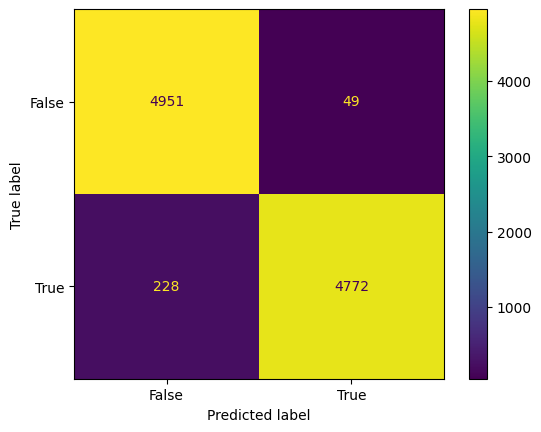

In [ ]:
# Make predictions and create a confusion matrix
actual = class_label[990000:1000000]
seq_predictions = my_model.predict(tensr_4_DM[990000:1000000, :, :, :])
seq_predictions = predictions
seq_predictions = list(map(lambda x: 0 if x < 0.5 else 1, seq_predictions))

# Calculate the confusion matrix using sklearn metrics
confusion_matrix = sklearn_metrics.confusion_matrix(actual, seq_predictions)

# Display the confusion matrix
cm_display = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

**All and all are summarized in these:**
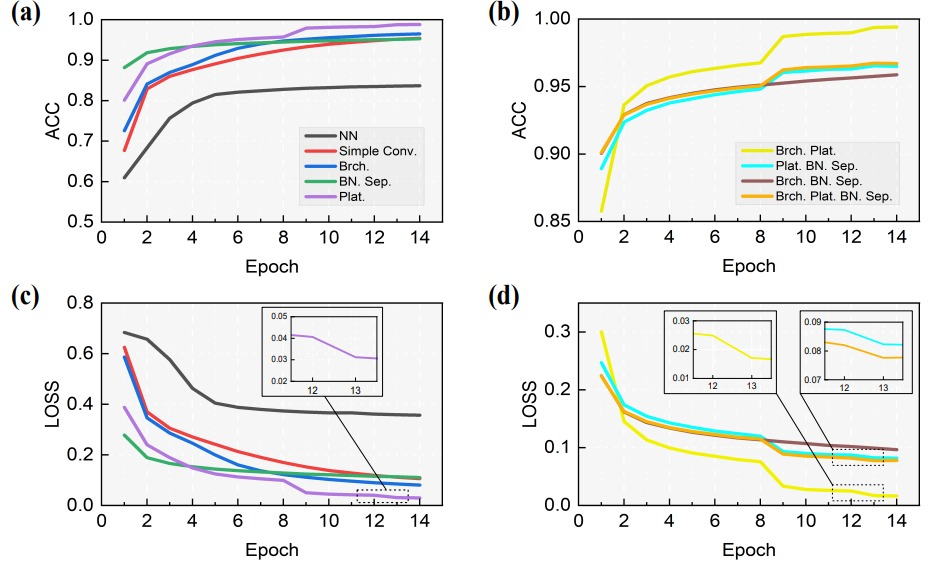